# Visualizing the Effects of Cholesterol and Blood Pressure on Heart Disease

*Mikel Ibarra Gallardo, Akshat Karla, Caitlin Lichimo, JunYuan Liu*

## Introduction

Heart disease is one of, if not the most common causes for death in the United States. The CDC estimates that approximately ⅕ deaths in the country are caused by it, with it being so severe that a person will die every 34 seconds because of heart disease. There are a variety of factors that can contribute to the likelihood of heart disease, along with the varieties that exist, with coronary heart disease (CAD) being the most common of them. Out of the contributing factors towards CAD, there are two in particular that are more influential: blood pressure and cholesterol level in plasma. Studies in the past have shown there to be a correlation between both blood pressure & cholesterol levels and heart disease. A study focusing on blood pressure found that it can be  a major risk factor towards CAD, especially with those who are over 35 and those diagnosed with hypertension (Jeremiah Statler, et al., 1989). Another study which focused on cholesterol found that it has a very strong correlation with CAD, due to the formation of fatty plaque within the arteries which is aided by low density proteolipids (Scott M. Grundy, 1986). The latter study, as well as the CDC, both suggest that one of the most efficient ways to prevent high cholesterol is through a change in diet, regular exercise, and a reduction of consumption of harmful substances (such as alcohol or tobacco). However, this research will be asking the following question: is cholesterol and/or blood pressure good predictors of heart disease?

We will be using the Heart Disease Data Set provided by UC Irvine. This data set describes heart condition information based on 303 individuals from different regions. This data is divided into 4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach, however we will only be utilizinng the Cleaveland data. The data set contains 76 attributes, but so far only 14 have been cited in literature:

- Age: age in years
- Sex: sex (1 = male; 0 = female)
- Cp: chest pain type (value 1 = typical angina, value 2 = atypical angina, value 3 = non-anginal pain, value 4 = asymptomatic)
- Trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- Chol: serum cholesterol in mg/dl
- Fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- Restecg: resting electrocardiographic results (value 0 = normal, value 1 = having ST-T wave abnormality, value 2 = showing probably or definite left ventricular hypertrophy by Estes’ criteria
- Thalach: maximum heart rate achieved
- Exang: exercise induced angina (1 = yes; 0 = no)
- Oldpeak: ST depression induced by exercise relative to rest
- Slope: the slope of the peak exercise ST segment (value 1 = upsloping, value 2 = flat, value 3 = downsloping)
- Ca: number of major vessels (0-3) colored by fluoroscopy
- Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect
- Num: diagnosis of heart disease (angiographic disease status) (value 0 = <50% diameter narrowing, value 1 = > 50% diameter narrowing)

# Methods

## Loading The Packages

#### Firstly, we load the required packages in R to get access to the required functions to perform our data analysis.

In [8]:
library(tidyverse)
library(tidymodels)
library(repr)

## Reading The Dataset


### Then, we load The Heart Disease dataset from the [link](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data) (UCI machine learning data base) by using the read_delim funciton in R.


##### For this Data Analysis, the data from Cleveland Dataframe is used
##### We will name our dataset **df_cleveland**

In [9]:
df_cleveland <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           ",", col_names = c("Age","Sex", "p","Trestbps", "Chol", "Fbs", "Restecg", "Thalach", "Exang",
                                              "Oldpeak", "Slope", "Ca", "Thal", "Num"))

head(df_cleveland,15)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Ca, Thal
dbl (12): Age, Sex, p, Trestbps, Chol, Fbs, Restecg, Thalach, Exang, Oldpeak...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,p,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


## Cleaning The Dataset

### After having a brief view of the raw data base, we could find

  - Some Questionary mark is inside the database which indicates lacking data
  - Also, the parameter indicates heart disease have 3 different values and not a optimal factor to train a classification model with binary variable. Therefore, we mutate it to the value 0 or 1 where 0 indicates no heart disease and 1 indicates heart disease.
  - Additionally, for the convenience of implementing classification model later, we mutate a new column Num2 which is a factor to indicate heart disease.

In [10]:
df_cleveland[df_cleveland == "?"] <- NA
df_cleveland <- mutate(df_cleveland, Num2 = Num/Num)
df_cleveland[df_cleveland == "NaN"] <- 0
df_cleveland <- df_cleveland |>
                    mutate(Num2 = as.factor(Num2))

head(df_cleveland,15)

Age,Sex,p,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Num,Num2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3,1
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2,1


**Table 1** The raw database is processed. The columns are named same to the online version of the database, all the entries with questionary mark are replaced with a NA value, and a new column named Num2 is created to store the binary variable that whether or not get heart disease.

## Exploring the Dataset

#### Following with processing the raw data, we want to understand the trend of those variable. Therefore, we draw three different scatter plot about three possible heart-disease-related variables which are indicated by documents.

The following figure is plotted in the following process:
- Two variable is used to plot a 2D scatter plot
- The scatter points are colored by whether or not the patient get heart disease 
  - cyan color (1) indicates having heart disease
  - orange color (0) indicates no heart disease 

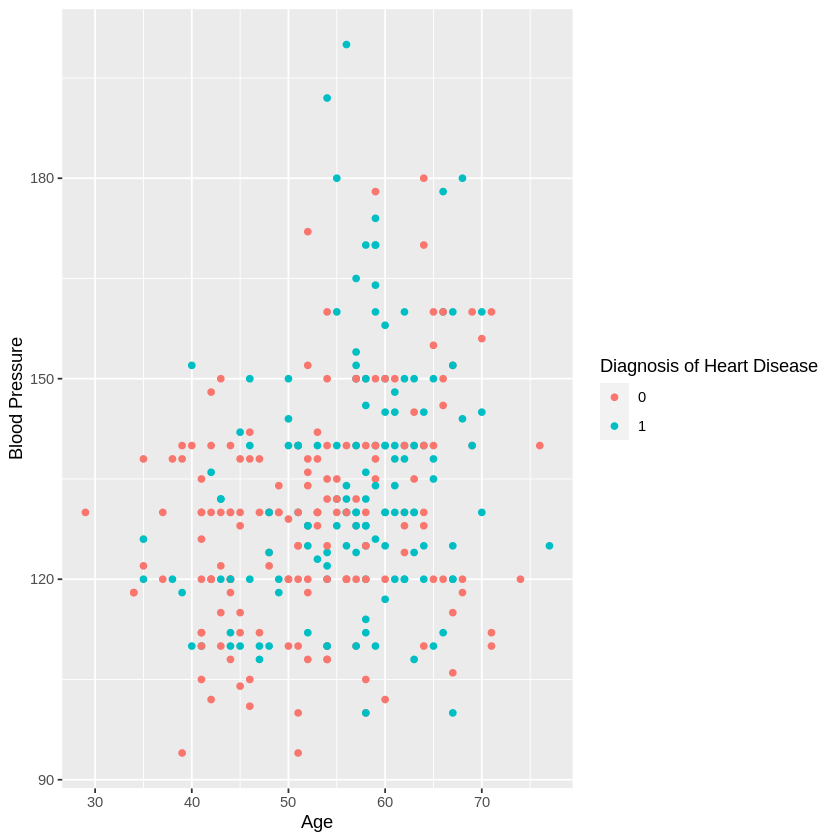

In [12]:
BP_vs_Age_plot <- df_cleveland |>
    ggplot(aes(x=Age,y=Trestbps, color=factor(Num2))) + 
        geom_point() +
        labs(x = "Age",y = "Blood Pressure", color = "Diagnosis of Heart Disease")
BP_vs_Age_plot

**Figure 1** In the figure blood pressure vs age above, we could find a significant trend that those data points colored by cyan (which indicates heart disease) is more likely distributed on the right side and also the top of the plot. This observation implies that age and blood pressure could be indicators for heart disease. 

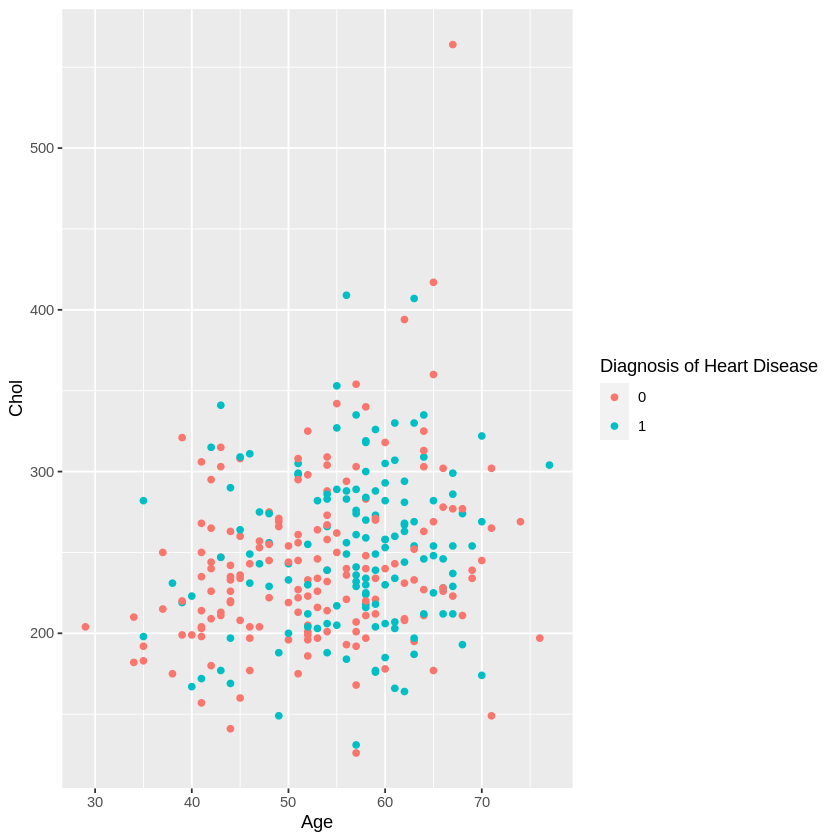

In [13]:
Chol_vs_Age_plot <- df_cleveland |>
    ggplot(aes(x=Age,y=Chol, color=factor(Num2))) + 
        geom_point() +
        labs(x = "Age",y = "Chol", color = "Diagnosis of Heart Disease")
Chol_vs_Age_plot

**Figure 2** In the figure cholesterol vs age above, we could find a correlative relation similar to Figure 1. Elder people are more likely to have heart disease. In the similar trend, more cyan points are posited at a high cholesterol position.

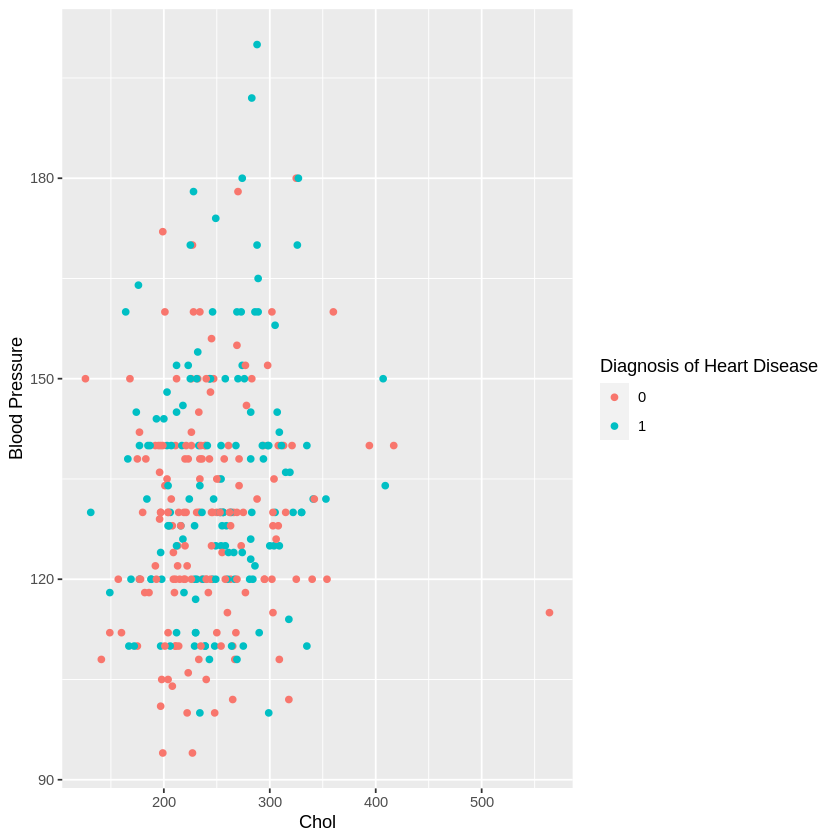

In [14]:
BP_vs_Chol_plot <- df_cleveland |>
    ggplot(aes(x=Chol,y=Trestbps, color=factor(Num2))) + 
        geom_point() +
        labs(x = "Chol",y = "Blood Pressure", color = "Diagnosis of Heart Disease")
BP_vs_Chol_plot

**Figure 3** In the figure blood pressure vs cholesterol, orange and cyan points mixed together. It indicates that the classification model only trained with blood pressure and cholesterol could not be a good model.

## Preprocessing the Data (Normalization)

Before we start train the classification model, we could observe that all three parameters: cholesterol, blood pressure, and age are not in the same order. It will significantly affect the classfication based on Euclidean distance. Therefore, we normalize the database first as following.

In [18]:
# normalization 
df_cleveland <- df_cleveland |>
  mutate(Age = scale(Age, center = TRUE),
         Trestbps = scale(Trestbps, center = TRUE),
         Chol = scale(Chol, center = TRUE))

head(df_cleveland,15)

Age,Sex,p,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Num,Num2
"<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
0.9471596,1,1,0.75627397,-0.26446281,1,2,150,0,2.3,3,0.0,6.0,0,0
1.3897030,1,4,1.60855891,0.75915934,0,2,108,1,1.5,2,3.0,3.0,2,1
1.3897030,1,4,-0.66420094,-0.34171732,0,2,129,1,2.6,2,2.0,7.0,1,1
-1.9293722,1,3,-0.09601098,0.06386882,0,0,187,0,3.5,3,0.0,3.0,0,0
-1.4868288,0,2,-0.09601098,-0.82455796,0,2,172,0,1.4,1,0.0,3.0,0,0
0.1727088,1,2,-0.66420094,-0.20652194,0,0,178,0,0.8,1,0.0,3.0,0,0
0.8365238,0,4,0.47217899,0.41151408,0,2,160,0,3.6,3,2.0,3.0,3,1
0.2833446,0,4,-0.66420094,2.07248588,0,0,163,1,0.6,1,0.0,3.0,0,0
0.9471596,1,4,-0.09601098,0.14112332,0,2,147,0,1.4,2,1.0,7.0,2,1


**Table 2** The first 15 row of the normalized database. All variables in the database is normalized and centered at 0.

## Splitting the Data into a training and test set

In [19]:
cleveland_split <- initial_split(df_cleveland, prop = 0.75, strata = Num2)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

cleveland_split

<Training/Testing/Total>
<227/76/303>

## Preprocessing the Data (Centering and Scaling

In [20]:
cleveland_recipe <- recipe(Num2 ~ Age + Trestbps, data = cleveland_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

## Training the Classifier

In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


## Performing Cross Validation

In [ ]:
set.seed(1)

cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = Num2)

## Creating a Tibble to Classify

In [ ]:
gridvals <- tibble(neighbors = seq(from = 1, to = 80, by = 5))

## Adding Everything into a Workflow

In [23]:
set.seed(1)

cleveland_results <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5500527,5,0.025229710,Preprocessor1_Model01
6,accuracy,binary,0.6036935,5,0.015505107,Preprocessor1_Model02
11,accuracy,binary,0.5954853,5,0.030505113,Preprocessor1_Model03
16,accuracy,binary,0.6171278,5,0.020611342,Preprocessor1_Model04
21,accuracy,binary,0.6396574,5,0.029855055,Preprocessor1_Model05
26,accuracy,binary,0.6215766,5,0.025409098,Preprocessor1_Model06
31,accuracy,binary,0.6214756,5,0.015374145,Preprocessor1_Model07
36,accuracy,binary,0.6214756,5,0.019445855,Preprocessor1_Model08
41,accuracy,binary,0.6079403,5,0.017095018,Preprocessor1_Model09


## Predicting the Accuracy

We can decide which K(neighbors) value would be the most optimal by plotting K VS Accuracy.

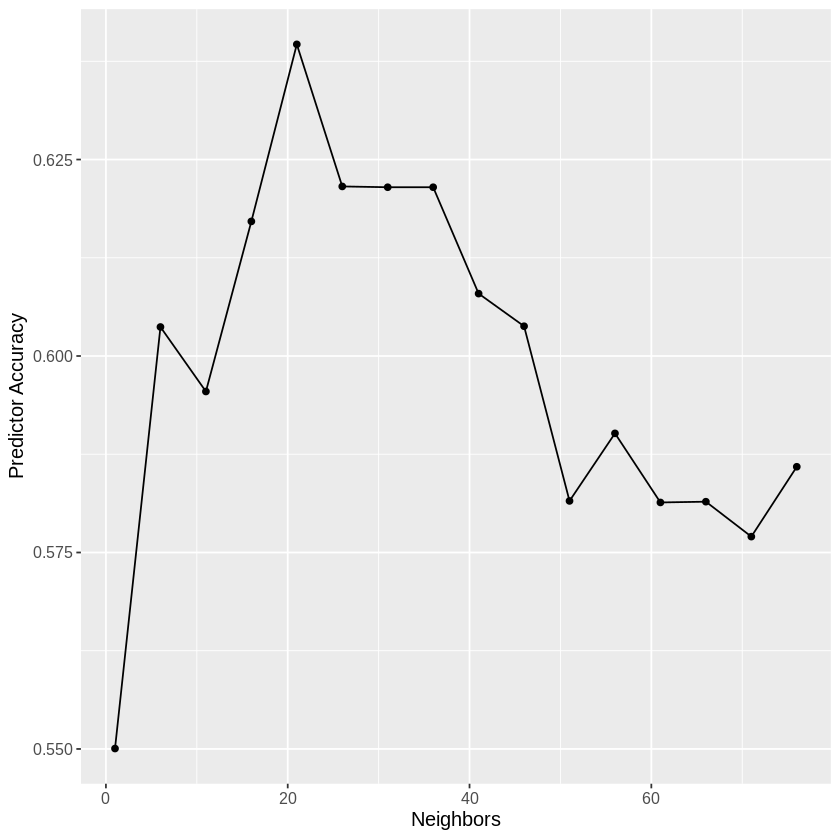

In [26]:
cleveland_bps_knn_plot <- cleveland_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors", y = "Predictor Accuracy") +
    theme(text = element_text(size = 12))

cleveland_bps_knn_plot

According the the graph

## Revising the Classifier

Now that we have our optimal K value, we will create a new classifier with K = 25 and name it as knn_best_spec.

In [42]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
            set_engine("kknn") |>
            set_mode("classification")

cleveland_recipe <- recipe(Num2 ~ Age + Trestbps, data = cleveland_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

cleveland_fit <- workflow() |>
                    add_recipe(cleveland_recipe) |>
                    add_model(knn_best_spec) |>
                    fit(data = cleveland_train)
knn_best_spec
cleveland_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 25
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(25,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3876652
Best kernel: rectangular
Best k: 25

#### Finally, we use the **predict** function to predict Num2

In [43]:
cleveland_prediction <- predict(cleveland_fit, cleveland_test) |>
                            bind_cols(cleveland_test)
head(cleveland_prediction)

.pred_class,Age,Sex,p,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Num,Num2
<fct>,"<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
0,-1.4868288,0,2,-0.09601098,-0.8245580,0,2,172,0,1.4,1,0.0,3.0,0,0
0,-0.1591988,1,4,0.47217899,-0.8438716,1,2,155,1,3.1,3,0.0,7.0,1,1
1,0.2833446,1,4,0.47217899,-1.0563215,0,0,148,0,0.4,2,0.0,6.0,0,0
1,0.2833446,1,3,1.04036895,-1.5198485,0,0,174,0,1.6,1,0.0,3.0,0,0
0,-0.7123780,0,3,-0.09601098,0.5467095,0,0,139,0,0.2,1,0.0,3.0,0,0
1,1.0577955,1,1,-1.23239090,-0.6893626,0,2,144,1,1.8,2,0.0,3.0,0,0


## Visualizing our Predictions

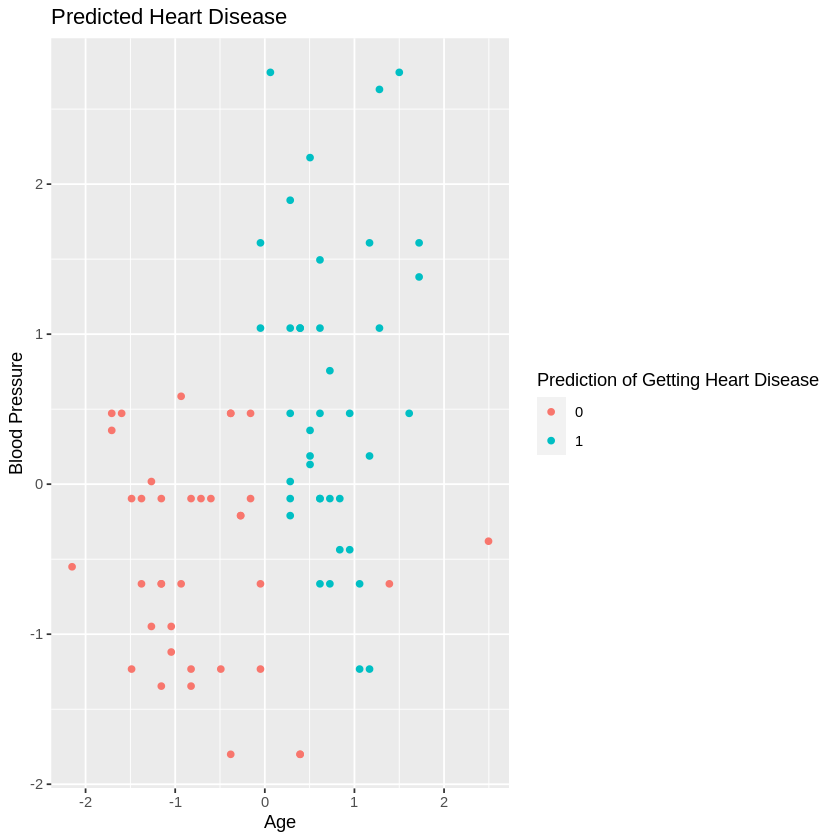

In [48]:
prediction_plot <- cleveland_testing_set_prediction |> 
        ggplot(aes(x=Age, y=Trestbps, color=factor(`.pred_class`))) + 
        geom_point() +
        labs(x = "Age",y = "Blood Pressure", color = "Prediction of Getting Heart Disease") + ggtitle("Predicted Heart Disease")
prediction_plot

**Figure 4** The predicted diagnosis of heart disease based on age and blood pressure of testing set. The scatter points are colored by cyan(1) indicates heart disease and orange(0) implies no heart disease. Two classes could be distinguish with clear boundary in the prediction.

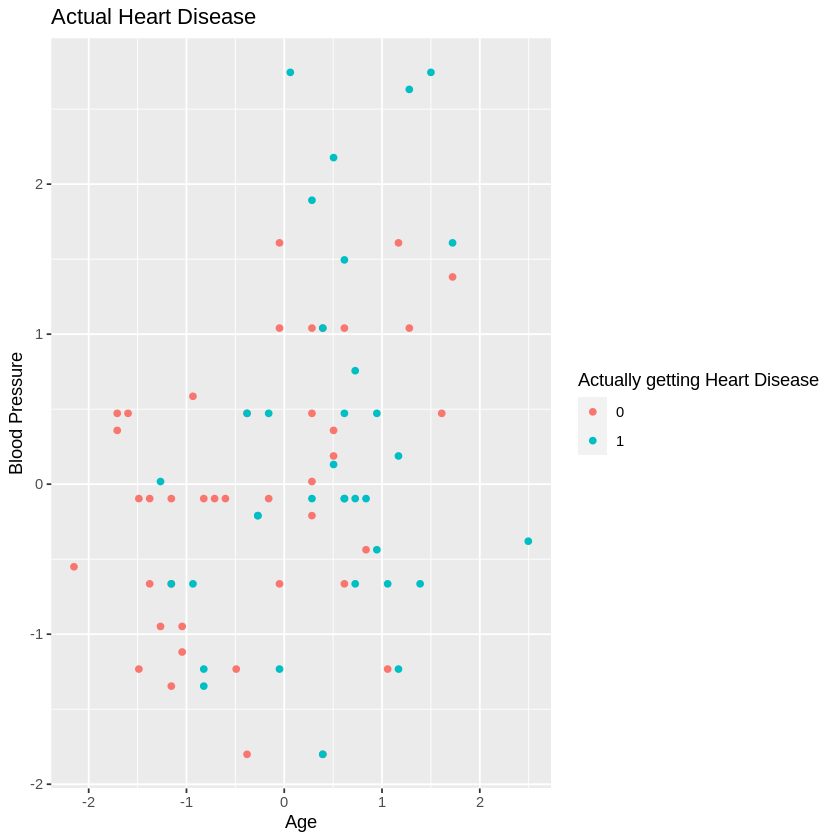

In [49]:
actual_plot <- cleveland_test |> ggplot(aes(x=Age, y=Trestbps, color=factor(Num2))) + 
        geom_point() +
        labs(x = "Age",y = "Blood Pressure", color = "Actually getting Heart Disease") + ggtitle("Actual Heart Disease")
actual_plot

**Figure 5** The actual diagnosis of heart disease based on age and blood pressure of testing set. The scatter points are colored by cyan(1) indicates heart disease and orange(0) implies no heart disease. We could find the trend of the actual diagnosis is similar to the prediction, but some data points are not predicted well.

## Now, we repeat the entire process with Cholestrol and Age as the Predictor Variables

In [50]:
set.seed(1)

cleveland_recipe <- recipe(Num2 ~ Age + Chol,data = cleveland_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = Num2)
gridvals <- tibble(neighbors = seq(from = 1, to = 80, by = 5))

cleveland_results <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

cleveland_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5547826,5,0.02636088,Preprocessor1_Model01
6,accuracy,binary,0.5806763,5,0.02903177,Preprocessor1_Model02
11,accuracy,binary,0.5725736,5,0.01154797,Preprocessor1_Model03
16,accuracy,binary,0.5636847,5,0.01697067,Preprocessor1_Model04
21,accuracy,binary,0.5844313,5,0.04480230,Preprocessor1_Model05
26,accuracy,binary,0.5980676,5,0.03395073,Preprocessor1_Model06
31,accuracy,binary,0.6113087,5,0.03655197,Preprocessor1_Model07
36,accuracy,binary,0.5987571,5,0.01782796,Preprocessor1_Model08
41,accuracy,binary,0.6030083,5,0.02068432,Preprocessor1_Model09


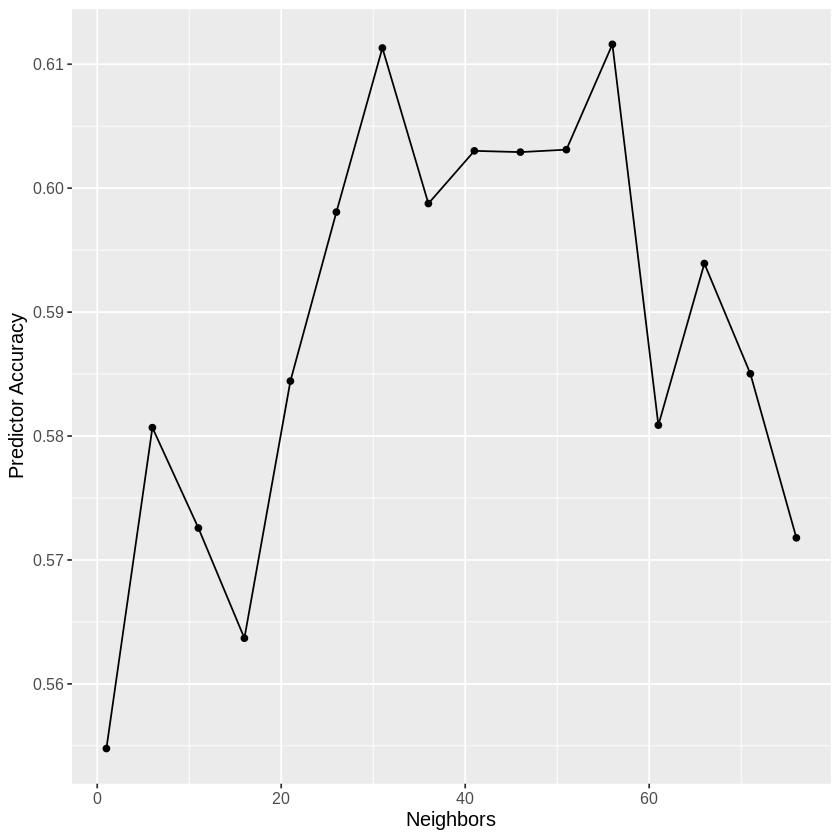

In [51]:
cleveland_bps_knn_plot <- cleveland_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors", y = "Predictor Accuracy") +
    theme(text = element_text(size = 12))

cleveland_bps_knn_plot

In [52]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) |>
            set_engine("kknn") |>
            set_mode("classification")

cleveland_recipe <- recipe(Num2 ~ Age + Chol, data = cleveland_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

cleveland_fit <- workflow() |>
                    add_recipe(cleveland_recipe) |>
                    add_model(knn_spec) |>
                    fit(data = cleveland_train)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(35,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4052863
Best kernel: rectangular
Best k: 35

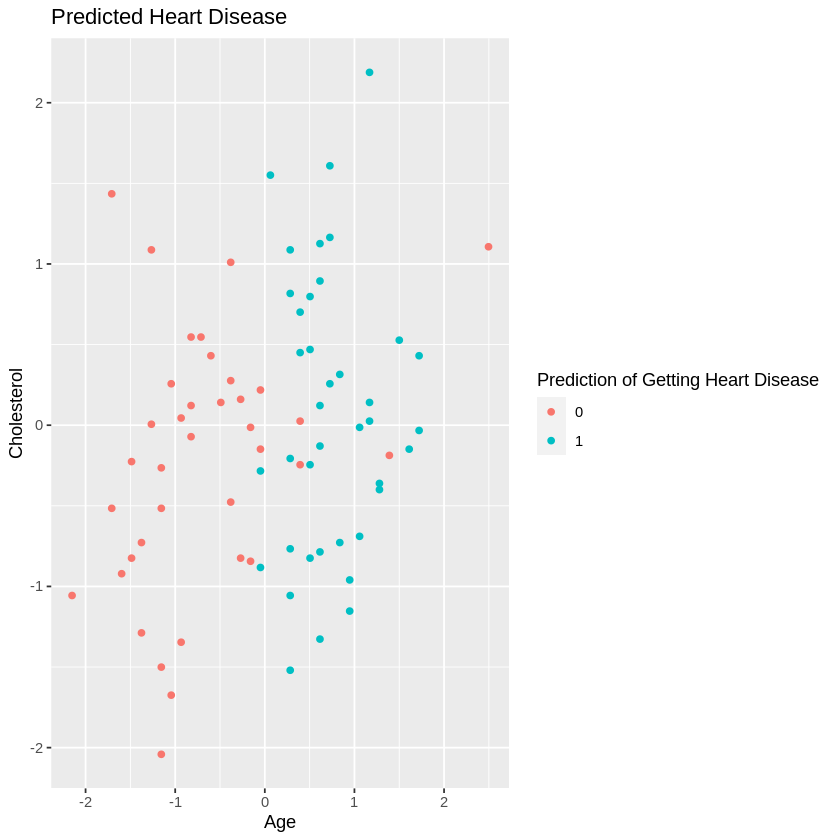

In [53]:
prediction_plot <- cleveland_testing_set_prediction |> ggplot(aes(x=Age, y=Chol, color=factor(`.pred_class`))) + 
        geom_point() +
        labs(x = "Age",y = "Cholesterol", color = "Prediction of Getting Heart Disease") + ggtitle("Predicted Heart Disease")
prediction_plot

**Figure 6** The predicted diagnosis of heart disease based on age and cholesterol of testing set. The scatter points are colored by cyan(1) indicates heart disease and orange(0) implies no heart disease. Two classes could be distinguish with clear boundary in the prediction.

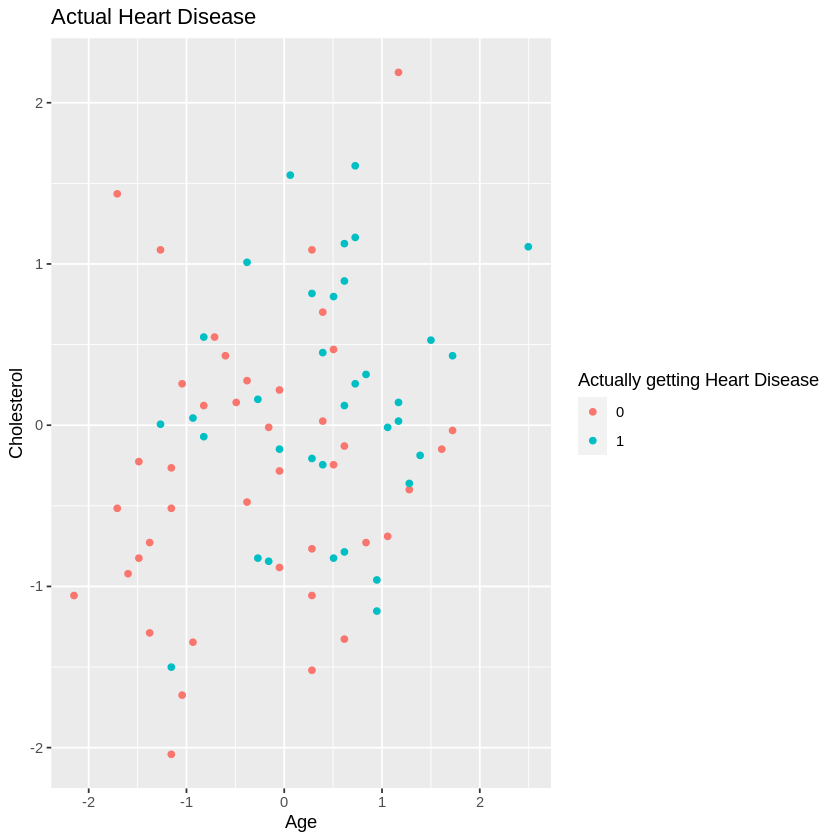

In [54]:
actual_plot <- cleveland_test |> ggplot(aes(x=Age, y=Chol, color=factor(Num2))) + 
        geom_point() +
        labs(x = "Age",y = "Cholesterol", color = "Actually getting Heart Disease") + ggtitle("Actual Heart Disease")
actual_plot

**Figure 7** The actual diagnosis of heart disease based on age and cholesterol of testing set. The scatter points are colored by cyan(1) indicates heart disease and orange(0) implies no heart disease. We could find the trend of the actual diagnosis is similar to the prediction, but some data points are not predicted well by comparison with predicted diagnosis.

Note: after the exposure of the model to testing set, we never feed it back to the training again since the exposure to testing set will affect the accuracy of the model which could diverge from actual accuracy and cannot reflect the wellness of the model. 

Read csv file online from github, then we store the database in a variable ?. 
We no

Read the database online and clean the database, etc…..

 

Since our goal is indicating the heart disease based on other observation and whether or not one gets  heart disease is a binary question, we choose to use classification on R to solve this problem.

 

We split the database into two part, the training set and testing set. Training set is used to train the model and testing set is used to test the accuracy of the model. Cross-validation is applied to the training set in order to find the best k-value we shall use into train the model.

 

As the RMSD (?) vs k-value shown, RMSD gets to minimum when k=?. Therefore, we pick k=? in training the model.

 

After the model is trained by training data set, we test the accuracy of the model by testing data set. Note: after running the testing set, we could not go back to the training set and train the model once more since it’s already exposed to the testing set.

## Discussion

Based on our results, cholesterol is the stronger indicator for diagnosing heart disease than blood pressure. We determine this by looking at the scatterplots - the points on the plot for cholesterol vs age are much more condensed than the points on the plot for blood pressure vs age, and thus we can see a stronger correlation (60% accuracy with k nearest neighbors algorithm). We did indeed expect to find that both cholesterol and blood pressure are significant indicators for heart disease, but we did not know which one would be stronger. However, although cholesterol can definitely be considered a strong indicator, it should not be utilized nor considered as the only one. For simplicity of this project, we chose only to consider two of the most common health issues in Americans. Future research should account for other indicative variables, such as the other 74 attributes from the UC Irvine Heart Disease Data Set (e.g., chest pain, maximum heart rate, number of major vessels, etc). The more we understand about potential indicators of heart disease, the better we can treat at-risk patients.

The biggest consequence of this high rate of heart disease is that it is the leading cause of death in America, with ⅕ deaths being caused by it (note that although our sample is only from Cleveland, we will interpret the results for the US as a whole). Adding to this, heart disease costs the country hundreds of billions of dollars in health care services which could instead be allocated towards other non-preventable medical needs. When looking at cholesterol and high blood pressure, the reduction of these is critical if one wishes to lower the likelihood of heart disease developing. That is not to say that by lowering cholesterol and high blood pressure levels one can fully prevent and avoid developing heart disease, but one can lower their chances of it happening. Further research in the future could focus on how people in the US can more efficiently control these factors, but also what can be done in order to aid them or to alleviate the responsibility of doing so independently and focus on improving health as a whole.

The CDC recommends several methods for preventing high blood pressure and cholesterol, all involving practicing healthier living habits. Eating a healthier diet, maintaining a healthier weight, staying physically active, not smoking, drinking less alcohol, and sleeping more are the most effective ways of preventing high blood pressure and cholesterol (Centers for Disease Control and Prevention, 2022). Another important method is to seek medical professional help. These practices seem fairly simple and intuitive, so why is heart disease such an issue in a well-developed country like the US? A big reason is due to the capitalist state of the country where the billions of dollars made from junky, processed food takes priority over the health of its citizens; junk food is cheap and healthy foods are becoming exceedingly expensive making it inaccessible to eat healthy. Another reason is a general lack of education; processed food companies make their nutrition facts labels confusing enough that the average citizen wouldn’t understand how to interpret the numbers (Health US News, 2012). Further research findings should also be readily accessible to the general public and should utilize accessible language for easy interpretation. Clear and concise publications in the form of infographics are an example of a way to effectively relay information to the public and avoid medical misinformation/mistrust, along with outreach programs in schools and workplaces, better access to recreational/physical activities, health care, and easily accessible nutrition.

## References

Centers for Disease Control and Prevention. (2022, October 14). Heart disease facts. Centers for Disease Control and Prevention. Retrieved October 24, 2022, from https://www.cdc.gov/heartdisease/facts.htm#:~:text=Heart%20disease%20is%20the%20leading,groups%20in%20the%20United%20States.&text=One%20person%20dies%20every%2034,United%20States%20from%20cardiovascular%20disease.&text=About%20697%2C000%20people%20in%20the,1%20in%20every%205%20deaths.

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved October 28, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease